*****
This is the first notebook I used for the final project. I will split the overall project into into multiple notebooks because I will have to re-run cells/the whole notebook in different scenarios and it would probably be better to avoid re-running ALL cells again and again, especially in cases where I have to restart the kernel. 

This first notebook will involve loading the scraped data from sqlite and then cleaning the data up to be usable. I will also do some visualization and other exploratory data analysis in this notebook. 

The next few notebooks will likely have any other analysis such as feature engineering and making other versions of the data, so that the data can be best used in the regression model. I will put the model code in its own notebook.
***** 

*****
I had to use google dev tools to find out how to do api queries when i loaded webpages, and get my browser cookie and use TLS to mimic real api queries to get the data returned as JSON format. This was tricky because tracker.gg has CLOUDFARE protection, so I had to do it in a round about way. I stored the data exactly as it was returned into a sqlite database under a table called 'matches'. Luckily, the JSON returns data in a nice fashion since its how it is displayed on the webpage   


I am going to load each table into a df and then check the contents and then make considerations on how to format it better, if i have to, and which information is most important, and identify if any columns should be kept/get rid of

*****

In [1]:
# i can load the sqlite table directly with python 
import pandas as pd
import sqlite3
conn = sqlite3.connect('marvel_rivals_FULL_REAL_FINAL.db')

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print(tables)



[('players',), ('profiles',), ('matches',), ('sqlite_sequence',)]


In [2]:
players = pd.read_sql_query('SELECT * FROM players', conn)

print(players.head())
print(players.info())
print(players.describe(include='all'))

    player_id        name region  rank  rank_score games
0    VP Sypeh    VP Sypeh   None     1      5308.0  None
1      Karova      Karova   None     2      5301.0  None
2          이페          이페   None     3      5296.0  None
3  Voldemortᅠ  Voldemortᅠ   None     4      5290.0  None
4   Екатерина   Екатерина   None     5      5288.0  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   player_id   966 non-null    object 
 1   name        966 non-null    object 
 2   region      0 non-null      object 
 3   rank        966 non-null    int64  
 4   rank_score  966 non-null    float64
 5   games       0 non-null      object 
dtypes: float64(1), int64(1), object(4)
memory usage: 45.4+ KB
None
       player_id name region         rank   rank_score games
count        966  966      0   966.000000   966.000000     0
unique       966  966      0        

In [3]:
profiles = pd.read_sql_query('SELECT * FROM profiles', conn)

print(profiles.head())
print(profiles.info())
print(profiles.describe(include='all'))

    player_id                                          json_data
0    VP Sypeh  [{"type": "overview", "attributes": {"season":...
1      Karova  [{"type": "overview", "attributes": {"season":...
2          이페  [{"type": "overview", "attributes": {"season":...
3  Voldemortᅠ  [{"type": "overview", "attributes": {"season":...
4   Екатерина  [{"type": "overview", "attributes": {"season":...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   player_id  588 non-null    object
 1   json_data  588 non-null    object
dtypes: object(2)
memory usage: 9.3+ KB
None
       player_id json_data
count        588       588
unique       588       586
top          Obv        []
freq           1         3


In [4]:
matches = pd.read_sql_query('SELECT * FROM matches', conn)

print(matches.head())
print(matches.info())
print(matches.describe(include='all'))

   id                             match_id    replay_id player_id player_name  \
0   1  5513730_1765074019_1318548_11001_12  10858083708  VP Sypeh    VP Sypeh   
1   2  6711722_1764888815_1272257_11001_22  50681325737  VP Sypeh    VP Sypeh   
2   3  6711647_1764886525_1245250_11001_22  50241126491  VP Sypeh    VP Sypeh   
3   4   506241_1764884213_1311009_11001_21  50560718078  VP Sypeh    VP Sypeh   
4   5   506105_1764882596_1310017_11001_21  50322526242  VP Sypeh    VP Sypeh   

          map_name    map_mode    mode_name                  timestamp  \
0   Celestial Husk  Domination  Competitive  2025-12-07T02:30:35+00:00   
1  Birnin T'Challa  Domination  Competitive  2025-12-04T23:06:27+00:00   
2   Spider-Islands      Convoy  Competitive  2025-12-04T22:36:46+00:00   
3           Arakko      Convoy  Competitive  2025-12-04T22:04:02+00:00   
4           Krakoa  Domination  Competitive  2025-12-04T21:29:38+00:00   

   duration_sec  ...  healing_per_min  rank_score      rank_tier  \


*****
**My 3 Tables are:**   
*players* - has all the players    
*profiles* - has each players' profile information (i need to expand it to see it more in depth)    
*matches* - each players' individual match data for up to last 25 matches    
    
    - NOTE: I (originally thought) i had to modify my project goal here, because I could not figure out a good way to get full match data through api queries, because they were non-distinguishable in the get requests, and obviously i dont have access to their data directly, nor do i have access to data directly through marvel rivals official channels   

*****

*****
Quick background on my ideas now that I don't have full team compositions for match data, but instead individual performance metrics for players: 

- I will instead focus on individual metrics/factors that impact game performance and win rates. This is also another factor that plays a big role in ability to win a match, so it is still very informative and fits the original motivations and significance of this project. It is one of the many angles to consider for match result prediction.  
- Players that play competitive mode have to be at least level 15, which means they have to play for about ~8hours before they can unlock competitive mode, which allows them to try out different heroes. 
- This data is from top lobbies, (top 1000 players), who are players with hundreds of hours in the game at minimum, so the data/statistics on individual performance based on profile data and match data is very valid and reliable to use as metrics (aka its very unlikely someone at this level will use a hero theyve never touched before in a match, without at least practicing with them enough to be sure they will not throw a match)
*****

In [5]:
profiles

,player_id,json_data
0,VP Sypeh,"[{""type"": ""overview"", ""attributes"": {""season"":..."
1,Karova,"[{""type"": ""overview"", ""attributes"": {""season"":..."
2,이페,"[{""type"": ""overview"", ""attributes"": {""season"":..."
3,Voldemortᅠ,"[{""type"": ""overview"", ""attributes"": {""season"":..."
4,Екатерина,"[{""type"": ""overview"", ""attributes"": {""season"":..."
...,...,...
583,RhythmIsKey,"[{""type"": ""overview"", ""attributes"": {""season"":..."
584,аmora,"[{""type"": ""overview"", ""attributes"": {""season"":..."
585,ORN_ghostillas,"[{""type"": ""overview"", ""attributes"": {""season"":..."
586,DecaDonald,"[{""type"": ""overview"", ""attributes"": {""season"":..."


In [6]:
profiles['json_data'].head()

0    [{"type": "overview", "attributes": {"season":...
1    [{"type": "overview", "attributes": {"season":...
2    [{"type": "overview", "attributes": {"season":...
3    [{"type": "overview", "attributes": {"season":...
4    [{"type": "overview", "attributes": {"season":...
Name: json_data, dtype: object

*****
Need to split up the data from json format into its own columns so i can read it and use the data
*****

In [7]:
# i can only run this cell 1 time, other it messes up the parsing (doin gjson loads 2 times will = error) !!
import json 
profiles['json_data'] = profiles['json_data'].apply(json.loads)
profiles

,player_id,json_data
0,VP Sypeh,"[{'type': 'overview', 'attributes': {'season':..."
1,Karova,"[{'type': 'overview', 'attributes': {'season':..."
2,이페,"[{'type': 'overview', 'attributes': {'season':..."
3,Voldemortᅠ,"[{'type': 'overview', 'attributes': {'season':..."
4,Екатерина,"[{'type': 'overview', 'attributes': {'season':..."
...,...,...
583,RhythmIsKey,"[{'type': 'overview', 'attributes': {'season':..."
584,аmora,"[{'type': 'overview', 'attributes': {'season':..."
585,ORN_ghostillas,"[{'type': 'overview', 'attributes': {'season':..."
586,DecaDonald,"[{'type': 'overview', 'attributes': {'season':..."


was getting errors for index out of range, checking if any lists empty

In [8]:
profiles[profiles["json_data"].apply(lambda x: isinstance(x, list) and len(x) == 0)]


,player_id,json_data
261,Adam Warlock,[]
465,Big Hen,[]
496,immortal rat,[]


removing these from list because missing data

#profiles = profiles[profiles['json_obj'].notnull()]   
profiles = profiles[profiles["json_data"].apply(lambda x: isinstance(x, list) and len(x) > 0)]

In [9]:
profiles[profiles["json_data"].apply(lambda x: isinstance(x, list) and len(x) == 0)]


,player_id,json_data
261,Adam Warlock,[]
465,Big Hen,[]
496,immortal rat,[]


In [10]:
profiles["json_data"].apply(type).value_counts()


json_data
<class 'list'>    588
Name: count, dtype: int64

In [11]:
profiles[profiles["json_data"].apply(lambda x: isinstance(x, list) and len(x) != 1)]


,player_id,json_data
0,VP Sypeh,"[{'type': 'overview', 'attributes': {'season':..."
1,Karova,"[{'type': 'overview', 'attributes': {'season':..."
2,이페,"[{'type': 'overview', 'attributes': {'season':..."
3,Voldemortᅠ,"[{'type': 'overview', 'attributes': {'season':..."
4,Екатерина,"[{'type': 'overview', 'attributes': {'season':..."
...,...,...
583,RhythmIsKey,"[{'type': 'overview', 'attributes': {'season':..."
584,аmora,"[{'type': 'overview', 'attributes': {'season':..."
585,ORN_ghostillas,"[{'type': 'overview', 'attributes': {'season':..."
586,DecaDonald,"[{'type': 'overview', 'attributes': {'season':..."


trying to understand how the json is formatted and how to break it apart

In [12]:
import json
#print(json.dumps(profiles["json_data"].iloc[0]))
print(json.dumps(profiles["json_data"].iloc[0], indent=4))


[
    {
        "type": "overview",
        "attributes": {
            "season": 10,
            "mode": "competitive"
        },
        "metadata": {
            "name": "Competitive"
        },
        "expiryDate": "0001-01-01T00:00:00+00:00",
        "stats": {
            "timePlayed": {
                "displayName": "Time Played",
                "displayCategory": "Game",
                "category": "game",
                "metadata": {},
                "value": 68547,
                "displayValue": "19h",
                "displayType": "TimeSeconds"
            },
            "matchesPlayed": {
                "displayName": "Matches Played",
                "displayCategory": "Game",
                "category": "game",
                "metadata": {},
                "value": 92,
                "displayValue": "92",
                "displayType": "Number"
            },
            "matchesWon": {
                "percentile": 81.0,
                "displayName": "Wins",


*****
So basically, the json is VERY long and it is separated into a bunch of separate json sections and I should break it up. A lot of this information might be good and a lot might be not useful, will have to see


The general things to note is that for each player profile, it is actually giving: 
 - OVERVIEW stats
 - Stats for **every distinct hero** in the game that **this player in particular** has used. This will be very useful to consider in later analysis when providing a recommendation of which hero to pick to maximize odds of winning, personalized to each player!!

*****

Im thinking of different ways to break up the data
Player id as a row, and a different column with hero and then columns for stats, but then this information would repeat again and again for a bunch of columns
Player id as a row, but repeat player id for each individual hero so there can be a clearer distinction? and then based on best hero stats can recommend that one? 
 - if i go with this option, i can actually plot the hero performance for each individual player more easily, have to think about how i would use this separation in modeling, maybe can make a criteria for figuring out top 3-5 heroes and then creating output summaries for those top 3 heroes per player and consider all the current match data for those heros, like the map, the type of match mode (domination, convoy, etc), and anything else

In [13]:
# break up json 
profiles["json_data"] = profiles["json_data"].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

rows = []

for col, row in profiles.iterrows(): #going through the df row by row
    player = row["player_id"] #get player id
    data_vals = row["json_data"] #get json data for that player
    
    for val in data_vals: #going through each entry in the json data 
        entry_type = val.get("type")
        
        # set names for specific hero values, a lot of the other info is junk
        if entry_type == "hero":
            hero_name = val.get("metadata", {}).get("name")
            hero_id = val.get("attributes", {}).get("heroId")
            season = val.get("attributes", {}).get("season")
            role = val.get("attributes", {}).get("role")
            
            # need to flatten stats otherwise its unusable
            #flattening has to happen one hero at a time bc of the json formatting, otherwise if applying to the whole column/df it will make a mess
            stats = val.get("stats", {})
            flat_stats = {}
            #manually flatten stats
            #looping over each hero entry in the list and flatten its stats
            for stat_key, stat in stats.items():
                flat_stats[f"{stat_key}_value"] = stat.get("value")
            
            # Build final row
            rows.append({
                "player_id": player,
                "hero_id": hero_id,
                "hero_name": hero_name,
                "season": season,
                "role": role,
                **flat_stats #this is how to unpack a dictionary w/o a loop !! (since the flat stats is a dictionary)
            })

hero_df = pd.DataFrame(rows)
hero_df


,player_id,hero_id,hero_name,season,role,timePlayed_value,timePlayedWon_value,matchesPlayed_value,matchesWon_value,matchesWinPct_value,...,featureHitRate2UseCount_value,featureHitRate2RealHitHeroCount_value,featureHitRate2ChaosHits_value,featureHitRate2AllyHits_value,featureHitRate2HeroHits_value,featureHitRate2EnemyHits_value,featureHitRate2ShieldHits_value,featureHitRate2SummonerHits_value,featureSpecialData1Total_value,featureSpecialData1Value_value
0,VP Sypeh,1058,Gambit,10,strategist,37388.742,24886.702,48.6,33.6,69.135802,...,None,None,None,None,None,None,None,None,NaN,NaN
1,VP Sypeh,1050,Invisible Woman,10,strategist,14769.481,8782.610,18.3,11.7,63.934426,...,None,None,None,None,None,None,None,None,NaN,NaN
2,VP Sypeh,1053,Emma Frost,10,vanguard,1275.047,870.015,1.4,1.0,71.428571,...,None,None,None,None,None,None,None,None,NaN,NaN
3,VP Sypeh,1016,Loki,10,strategist,7069.450,6664.969,11.8,11.0,93.220339,...,None,None,None,None,None,None,None,None,NaN,NaN
4,VP Sypeh,1046,Adam Warlock,10,strategist,2216.817,1340.044,3.0,1.6,53.333333,...,None,None,None,None,None,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8102,DecaDonald,1018,Doctor Strange,10,vanguard,1493.608,942.512,2.3,1.3,56.521739,...,None,None,None,None,None,None,None,None,NaN,NaN
8103,DecaDonald,1020,Mantis,10,strategist,502.765,0.000,0.5,0.0,0.000000,...,None,None,None,None,None,None,None,None,NaN,NaN
8104,DecaDonald,1051,The Thing,10,vanguard,173.163,0.000,0.5,0.0,0.000000,...,None,None,None,None,None,None,None,None,NaN,NaN
8105,DecaDonald,1055,Daredevil,10,duelist,3.931,3.931,0.0,0.0,0.000000,...,None,None,None,None,None,None,None,None,NaN,NaN


I have 8107 rows instead of the original 585. To note, 585/1000 originally because many player profiles are PRIVATE, so they cannot be read. These are the profiles that were not PRIVATE. 

There is a total of 44 heroes in the game as of s5 in December (another hero will be released in the next few weeks for the next update)      
    
so 585*44= 25,740. HOWEVER, there are not this many rows in the dataframe above. This is because upon examining the json manually, I see that there is not data for EVERY hero in the game per player. I did some digging and it is because data for heroes that a player has NEVER PLAYED is not included. Also, this dataset is SPECIFIC to COMPETITIVE mode only. This means that each player does not have 44 hero entries, only those for the heroes they've played. Which makes sense, and it doesnt hurt my analysis as im considering the top 3-5 heroes anyway.        
    
Also, this is normal behavior. I have some heroes that i never touched until recently for fun, but I would never play a vast majority of heroes in COMPETITIVE becasue I only play those I am very good at, and dont want to lose a match, also because they simply dont interest me or match my play style. For top players, they come from other classical hero shooters, so they have certain roles they are already acustomed to/stick to playing, so for example Sypeh, a Support main, will not play a hero like black panther, especially not in competitive matches. 

*****
testing basic plot for Sypeh's heroes played based on playtime
*****

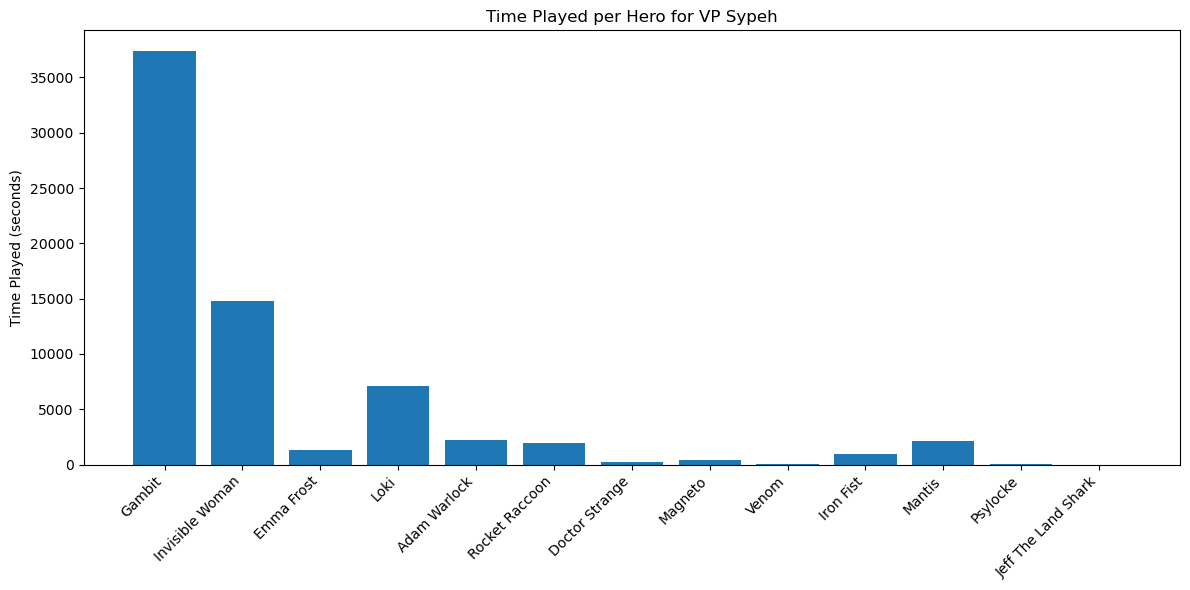

In [14]:
import matplotlib.pyplot as plt

#select all rows that have that player string
player = "VP Sypeh"
player_data = hero_df[hero_df.player_id == player]

#and then check the column values that match for all matched "VP Sypeh" rows
plt.figure(figsize=(12, 6))
plt.bar(player_data["hero_name"], player_data["timePlayed_value"]) 

plt.xticks(rotation=45, ha="right")
plt.ylabel("Time Played (seconds)")
plt.title(f"Time Played per Hero for {player}")

plt.tight_layout()
plt.show()


Of note: Gambit just came out in season 5 (few weeks ago)   

The reason the playtime distribution is as so is bc Sypeh has 4 accounts, and has gotten all 4 to rank top 100, so younger accounts like this have playtime distribution like this (not a very normal thing players have, but this is important to note)

I want to see stuff like what the top played heroes are, top win rates heroes, etc. 

In [15]:
player = "VP Sypeh"
vp_sypeh = hero_df[hero_df.player_id == player]
top_played_vp_sypeh = vp_sypeh.sort_values("timePlayed_value", ascending=False)
top_played_vp_sypeh

,player_id,hero_id,hero_name,season,role,timePlayed_value,timePlayedWon_value,matchesPlayed_value,matchesWon_value,matchesWinPct_value,...,featureHitRate2UseCount_value,featureHitRate2RealHitHeroCount_value,featureHitRate2ChaosHits_value,featureHitRate2AllyHits_value,featureHitRate2HeroHits_value,featureHitRate2EnemyHits_value,featureHitRate2ShieldHits_value,featureHitRate2SummonerHits_value,featureSpecialData1Total_value,featureSpecialData1Value_value
0,VP Sypeh,1058,Gambit,10,strategist,37388.742,24886.702,48.6,33.6,69.135802,...,None,None,None,None,None,None,None,None,NaN,NaN
1,VP Sypeh,1050,Invisible Woman,10,strategist,14769.481,8782.610,18.3,11.7,63.934426,...,None,None,None,None,None,None,None,None,NaN,NaN
3,VP Sypeh,1016,Loki,10,strategist,7069.450,6664.969,11.8,11.0,93.220339,...,None,None,None,None,None,None,None,None,NaN,NaN
4,VP Sypeh,1046,Adam Warlock,10,strategist,2216.817,1340.044,3.0,1.6,53.333333,...,None,None,None,None,None,None,None,None,NaN,NaN
10,VP Sypeh,1020,Mantis,10,strategist,2171.255,174.548,3.0,0.4,13.333333,...,None,None,None,None,None,None,None,None,NaN,NaN
5,VP Sypeh,1023,Rocket Raccoon,10,strategist,1972.962,1455.095,3.4,2.6,76.470588,...,None,None,None,None,None,None,None,None,NaN,NaN
2,VP Sypeh,1053,Emma Frost,10,vanguard,1275.047,870.015,1.4,1.0,71.428571,...,None,None,None,None,None,None,None,None,NaN,NaN
9,VP Sypeh,1052,Iron Fist,10,duelist,919.214,360.764,1.4,0.9,64.285714,...,None,None,None,None,None,None,None,None,NaN,NaN
7,VP Sypeh,1037,Magneto,10,vanguard,433.098,0.000,0.6,0.0,0.000000,...,None,None,None,None,None,None,None,None,NaN,NaN
6,VP Sypeh,1018,Doctor Strange,10,vanguard,203.114,103.251,0.2,0.1,50.000000,...,None,None,None,None,None,None,None,None,NaN,NaN


In [16]:
#get all column values into a text file 
top_played_vp_sypeh.to_csv("top_played_vp_sypeh.csv", sep=",", index=False)

Useful columns:  
 - hero_name
 - role (THIS IS VERY IMPORTANT --> I am going to do feature engineering to make a calculation where I place more emphasis on certain values of performance, like healing for support, damage and final kills for duelist, damage blocked for vangaurd, because different roles have certain stats that matter MORE than others as they directly relate to the performance of their ROLE)
 - matchesWinPct_value (match win %)
 - timePlayed_value
 - kdaRatio_value (KDA = kills/deaths/assists ratio --> kills+assists / deaths --> more meaningful to compare across roles)
 - kdRatio_value (I REALIZED AFTER FIRST VISUALIZATIONS, THAT KDA IS SKEWED IN FAVOR OF SUPPORTS)
 - totalHeroDamagePerMinute_value (i have to do PER MINUTE values bc otherwise its an accumulated value across games, which is not comparable due to differences in playtime)
 - totalHeroHealPerMinute_value
 - totalDamageTakenPerMinute_value
 - lastKills_value (this is the final hits value i think, very useful bc its not just elims (who contributed) but the final hit to get an elimination on an opponent)
 - totalMvp_value
 - totalSvp_value
 - 

**TRIMMED HERO DATAFRAME WITH MOST IMPORTANT COLUMNS**

In [17]:
trimmed_hero_df = hero_df[["player_id", "hero_name", 'role', 'timePlayed_value', 'matchesWinPct_value', 'matchesPlayed_value', 'kdRatio_value', 'kdaRatio_value', 'totalHeroDamagePerMinute_value', 'totalHeroHealPerMinute_value', 'totalDamageTakenPerMinute_value', 'lastKills_value', 'totalMvp_value', 'totalSvp_value']]
trimmed_hero_df

,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8102,DecaDonald,Doctor Strange,vanguard,1493.608,56.521739,2.3,2.315789,2.526316,1234.0,6.0,2616.0,17,0,0
8103,DecaDonald,Mantis,strategist,502.765,0.000000,0.5,0.500000,2.500000,720.0,946.0,1222.0,1,0,0
8104,DecaDonald,The Thing,vanguard,173.163,0.000000,0.5,1.000000,1.333333,678.0,0.0,2374.0,1,0,0
8105,DecaDonald,Daredevil,duelist,3.931,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0,0,0


*****
APPLYING FILTERS TO DATA SET 
*****

I dont think that any hero data where these players have less than a certain amount of time on is useful.  

A match can be roughly around 10-30 minutes.   

So im going to just remove any rows that have 'timePlayed_value' < 15 minutes = 15*60 = 900 seconds.    

 I think that since these are top players, some with alt accounts, they could use characters in specific situations but i think that there isnt much useful information for some of these as the numbers are very skewed for heroes theyve barely played. For example, theres an entry for DecaDonald playing Luna Snow for 828 total sceconds and has a 100% win rate with her. The recommendation would probably end up recommending them to play Luna Snow, but it could have just been a one-off event where they played her and won the match. I think at least 15 minutes of play time on a hero is important to avoid skewing data. 

In [18]:
trimmed_hero_df = trimmed_hero_df[trimmed_hero_df['timePlayed_value'] >= 900] #filtering out rows that have less than 10 min of playtime for a hero
trimmed_hero_df

,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8097,DecaDonald,Loki,strategist,37808.155,57.201646,48.6,2.886207,7.500000,701.0,2287.0,642.0,154,6,6
8098,DecaDonald,Invisible Woman,strategist,9567.059,33.628319,11.3,2.098901,5.571429,677.0,2592.0,1288.0,26,0,0
8099,DecaDonald,Rocket Raccoon,strategist,13100.055,59.067358,19.3,1.400000,6.410526,207.0,1988.0,444.0,30,0,0
8100,DecaDonald,Venom,vanguard,1613.943,40.000000,2.5,2.117647,2.941176,1095.0,0.0,2685.0,17,0,0


Given what i said above, i also want to get a sense of how much overall time each player spends on playing a specific hero. 
    
I want to get the percentage of their total time played of a hero, and put that in its own column. 

In [19]:
trimmed_hero_df['percent_of_time_played'] = (trimmed_hero_df['timePlayed_value'] / trimmed_hero_df.groupby('player_id')['timePlayed_value'].transform('sum')) * 100
trimmed_hero_df

C:\Users\Nazir\AppData\Local\Temp\ipykernel_5540\1056433356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_hero_df['percent_of_time_played'] = (trimmed_hero_df['timePlayed_value'] / trimmed_hero_df.groupby('player_id')['timePlayed_value'].transform('sum')) * 100


,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7,55.159494
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5,21.789369
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0,1.881073
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0,10.429537
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0,3.270463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8097,DecaDonald,Loki,strategist,37808.155,57.201646,48.6,2.886207,7.500000,701.0,2287.0,642.0,154,6,6,37.585012
8098,DecaDonald,Invisible Woman,strategist,9567.059,33.628319,11.3,2.098901,5.571429,677.0,2592.0,1288.0,26,0,0,9.510594
8099,DecaDonald,Rocket Raccoon,strategist,13100.055,59.067358,19.3,1.400000,6.410526,207.0,1988.0,444.0,30,0,0,13.022739
8100,DecaDonald,Venom,vanguard,1613.943,40.000000,2.5,2.117647,2.941176,1095.0,0.0,2685.0,17,0,0,1.604418


*****
Other than this, additional columns that I want to add that I will have to extract from the individual match data that I collected in the matches table, is things such as the MAP, and the MATCH TYPE/MODE.  

I think these 2 things are important covariates to consider that affect decision making, because some heroes provide advantages on certain maps, due to things like enclosed spaces/open spaces, high ceilings/low ceilings, and general map layout/structure, as well as match type (domination = capture the point mechanism w/ best of 3 rounds, convoy = push the cart mechanism, convergence = capture a point, then push a cart ; for convoy/convergence teams swap to play attack/defense each round (total 2 rounds))
*****

So, for each player i want to make a similar table as the trimmed hero table but with individual matches for each player, with each line being a player id, match id, and then the match data, for as many matches that were collected.    

Then from here, I want to calculate the win% for each hero for each game mode, and then the same but for each map.   

I think then incorporating the win rate for each map and each game mode into the trimmed hero table will provide another important metric/covariate into the regression model. Each map can be included as a feature, and if one map is selected, then that weight will be considered, and the rest will be set to 0. 

Looking at the match dataframe now to collect & calculate this information:

In [20]:
matches.head()

,id,match_id,replay_id,player_id,player_name,map_name,map_mode,mode_name,timestamp,duration_sec,...,healing_per_min,rank_score,rank_tier,rank_tier_short,rank_delta,last_kills,head_kills,solo_kills,damage_blocked,damage_blocked_per_min
0,1,5513730_1765074019_1318548_11001_12,10858083708,VP Sypeh,VP Sypeh,Celestial Husk,Domination,Competitive,2025-12-07T02:30:35+00:00,381,...,2474.60,5308.0,One Above All,OAA,13.0,1.0,0.0,0.0,6147.800565,1024.63
1,2,6711722_1764888815_1272257_11001_22,50681325737,VP Sypeh,VP Sypeh,Birnin T'Challa,Domination,Competitive,2025-12-04T23:06:27+00:00,537,...,3281.41,5295.0,One Above All,OAA,13.0,3.0,0.0,2.0,11893.105869,1486.64
2,3,6711647_1764886525_1245250_11001_22,50241126491,VP Sypeh,VP Sypeh,Spider-Islands,Convoy,Competitive,2025-12-04T22:36:46+00:00,1015,...,4511.28,5281.0,One Above All,OAA,16.0,6.0,0.0,0.0,25389.681012,1586.86
3,4,506241_1764884213_1311009_11001_21,50560718078,VP Sypeh,VP Sypeh,Arakko,Convoy,Competitive,2025-12-04T22:04:02+00:00,1187,...,4248.56,5264.0,One Above All,OAA,15.0,9.0,0.0,0.0,13422.148777,706.43
4,5,506105_1764882596_1310017_11001_21,50322526242,VP Sypeh,VP Sypeh,Krakoa,Domination,Competitive,2025-12-04T21:29:38+00:00,883,...,3533.89,5248.0,One Above All,OAA,-23.0,5.0,0.0,2.0,22387.621352,1599.12


*****
**A revelation has been made** :

The first value of this JSON is the long version of the match id. I thought this *particular value* looked familiar.   

I went back to the tracker.gg website and clicked to open a match scoreboard in a *new tab*. I opened google develepor window and found the GET request.   

The first time I looked at this I thought it was nonsense. However now....    

Example of what one of the get requests looks like for the API:    
https://api.tracker.gg/api/v2/marvel-rivals/standard/matches/5513562_1764654765_1291214_11001_12

This means that I **CAN** actually extract match data. SPECIFICALLY the matches that I know exist, and can get insights into team compositions that I thought I couldn't get before.   

I think this was only possible BECAUSE I found this specific match id value from this json file for the matches. Because this match id value is UNIQUE to tracker.gg, and it is NOT the same as the replay id which is what is found within the game, where you can search up replays of matches with the replay id, which likely refreshes for old matches that are no longer available, but tracker.gg has their own way of keeping track of ALL matches in their database. 

What's even better is I can remove duplicates and literally loop through API requests using the specific match id now.  

I will do this and place it into its own SQL table with my current updated cookie everything. 

*****

In [21]:
match_id_master_list = matches['match_id'].unique()
pd.Series(match_id_master_list).to_csv("match_id_master_list.txt", header=False, index=False)
print(len(match_id_master_list))
match_id_master_list


5418


array(['5513730_1765074019_1318548_11001_12',
       '6711722_1764888815_1272257_11001_22',
       '6711647_1764886525_1245250_11001_22', ...,
       '5517426_1765100984_1267184_11001_11',
       '5513998_1765096434_1291511_11001_12',
       '5513925_1765094719_1231224_11001_12'], shape=(5418,), dtype=object)

I know have a list of 5,418 unique match ids!!!   

If I collect all the json data associated with these matches, I will be able to extract some serious information about team compositions for top ranked matches from the best of the best. I will run this with my api caller/scraper to get this information and store it into a sqlite database. 


*****
I will create a 2nd notebook to do that. In the meantime, I will make sure to get those values that I mentioned, the win rates per map and per game mode per character that each player played

*****

*****

I want to do some visualizations really quick 

*****

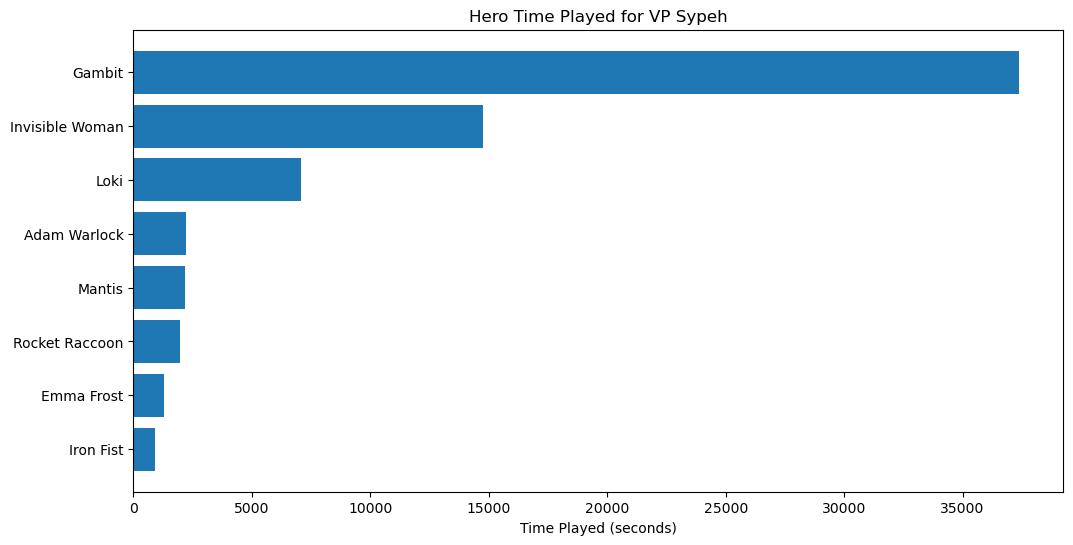

In [22]:
player = "VP Sypeh"
p = trimmed_hero_df[trimmed_hero_df.player_id == player].sort_values("timePlayed_value")

plt.figure(figsize=(12,6))
plt.barh(p["hero_name"], p["timePlayed_value"])
plt.xlabel("Time Played (seconds)")
plt.title(f"Hero Time Played for {player}")
plt.show()


This is just another plot of what i did earlier, play time and heroes. 

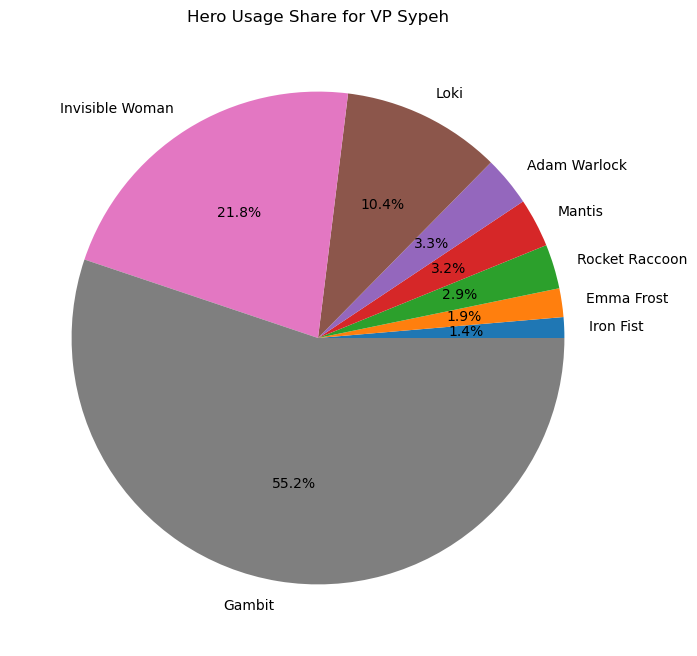

In [23]:
plt.figure(figsize=(8,8))
plt.pie(p["percent_of_time_played"], labels=p["hero_name"], autopct="%1.1f%%")
plt.title(f"Hero Usage Share for {player}")
plt.show()


I am just playing around with another way to see the hero playtime distribution

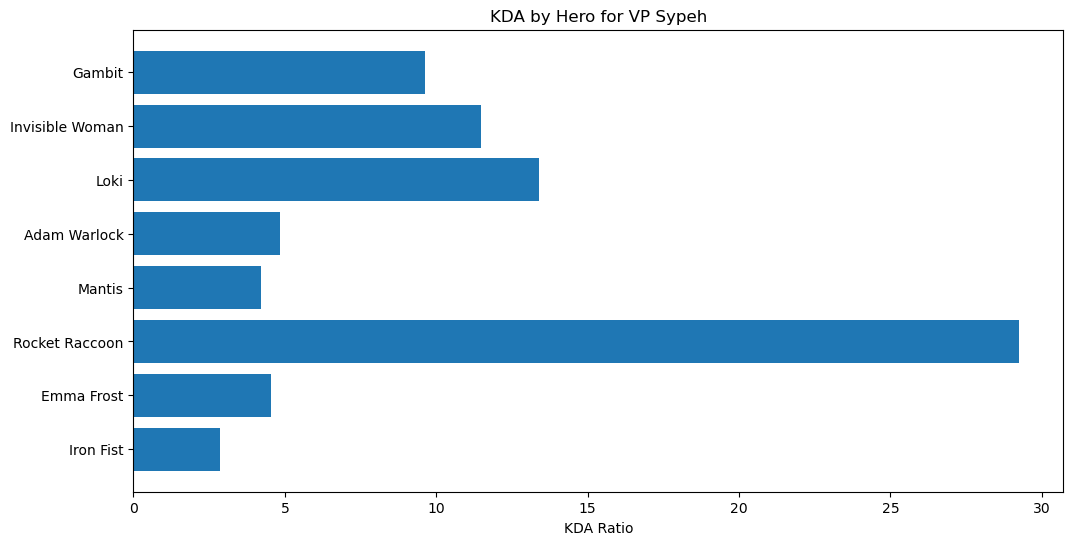

In [24]:
plt.figure(figsize=(12,6))
plt.barh(p["hero_name"], p["kdaRatio_value"])
plt.xlabel("KDA Ratio")
plt.title(f"KDA by Hero for {player}")
plt.show()



I do want to see the KDA ratio distribution of each hero. Now one thing to note is that Rocket Raccoon is the type of hero to essentially farm assists stat because his heal orb does healing/time (not burst/immediate healing of a certain value), so it actually results in more assists over time, and thus a higher kda ratio. 

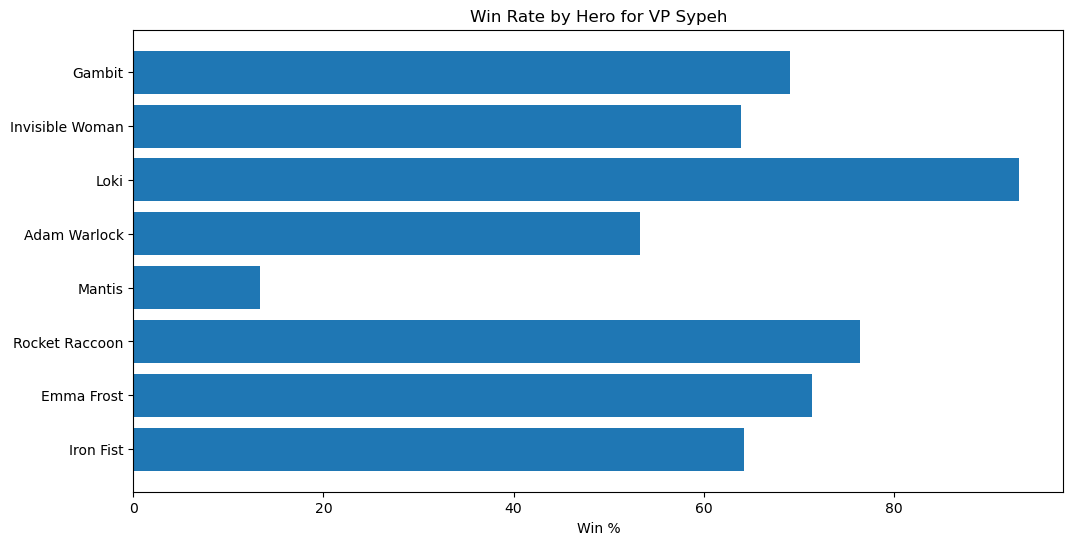

In [25]:
plt.figure(figsize=(12,6))
plt.barh(p["hero_name"], p["matchesWinPct_value"])
plt.xlabel("Win %")
plt.title(f"Win Rate by Hero for {player}")
plt.show()


Win% breakdown is very important. I would say at minimum heroes with > 50% win rate is a necessity.   

Now, heroes with > 60% win rate are exceptionally good, but it is important to remember that playtime should be considered when thinking about win rate. You can play few matches with a hero, happen to do good and have an abnormally high winrate.   

Looking at Sypeh's top 3 playtime characters from the earlier plot, it is Gambit, Invisible Woman, and Loki. So specifically zoning in on these 3 heroes, the win rate is very high!!! 

From this I could conclude that these characters are more likely to be recommended to play, using just these 2 features, because of high playtime and high win %. 

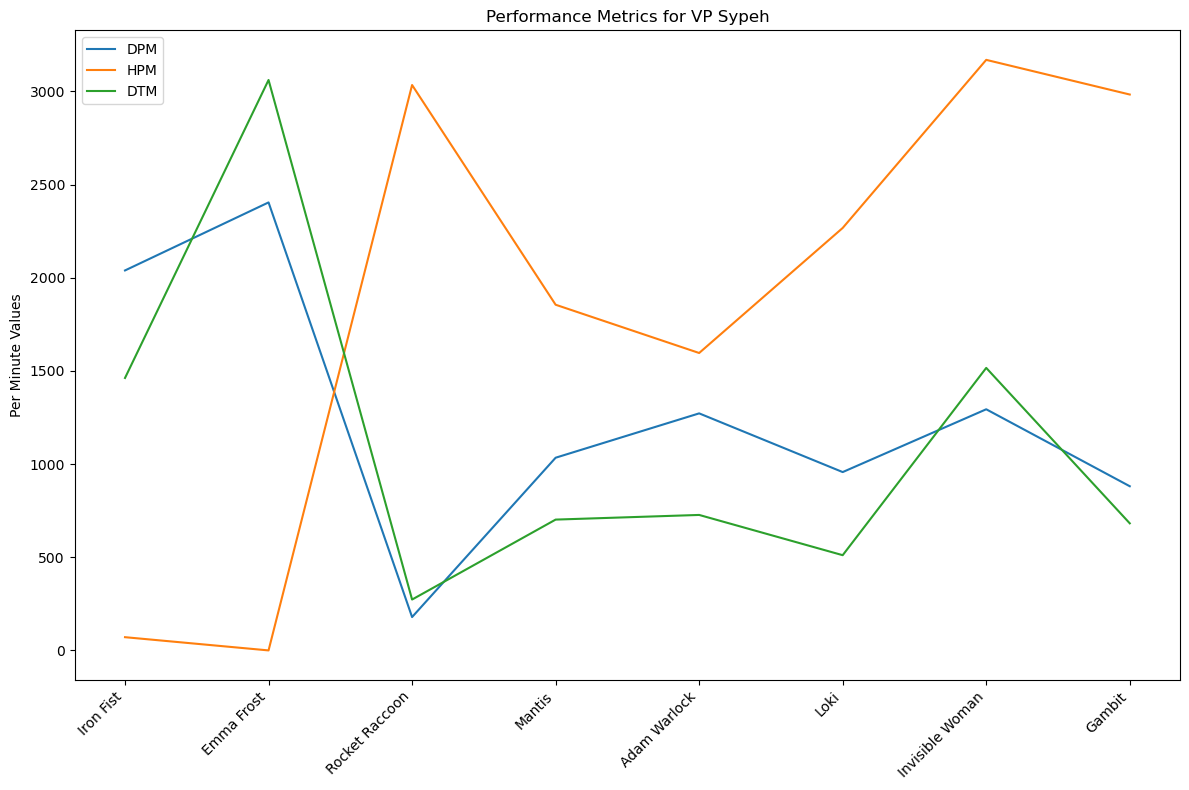

In [26]:
plt.figure(figsize=(12,8))
plt.plot(p["hero_name"], p["totalHeroDamagePerMinute_value"], label="DPM")
plt.plot(p["hero_name"], p["totalHeroHealPerMinute_value"], label="HPM")
plt.plot(p["hero_name"], p["totalDamageTakenPerMinute_value"], label="DTM")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Per Minute Values")
plt.title(f"Performance Metrics for {player}")
plt.legend()
plt.tight_layout()
plt.show()


This is an ugly way of plotting it but i wanted to see all 3 to directly compare per hero   

I am thinking maybe to make a consideration for this for a role. Like a support should have higher emphasis or 'points' for good performance in healing per minute, as that is their main role (healing) but having good damage along with that is a bonus. Damage blocked doesnt really matter for support characters, although it might give insights into explaining how much they died, or low deaths and high damage blocked could show their fellow supports kept them alive or they used special abilities (invisible woman shield) to stay alive longer. But i think that since damage taken/blocked is so sporadic in terms of explanation for a support player (matters for tank/vanguard over any other role) that I will probably instead just place emphasis on the most direct, crucial stat per role.   

This will be: 

 - totalHeroDamagePerMinute_value -> Duelist (DPS)
 - totalHeroHealPerMinute_value -> Strategist (SUPPORT)
 - totalDamageTakenPerMinute_value -> Vanguard (TANK)

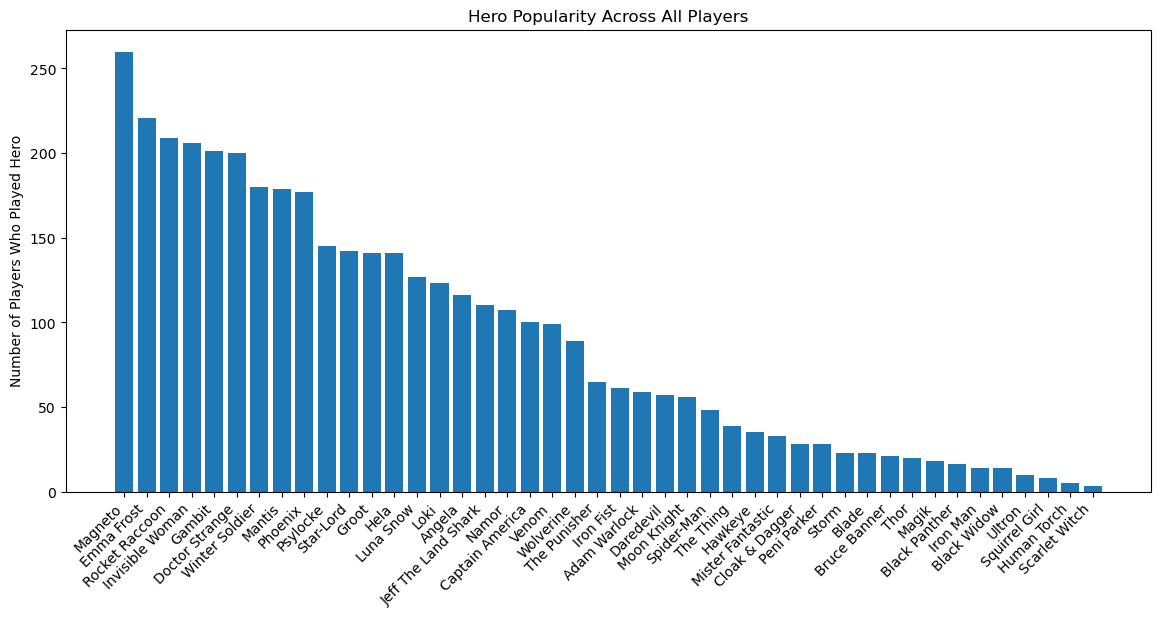

In [27]:
hero_counts = trimmed_hero_df["hero_name"].value_counts()

plt.figure(figsize=(14,6))
plt.bar(hero_counts.index, hero_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Hero Popularity Across All Players")
plt.ylabel("Number of Players Who Played Hero")
plt.show()


This is a distribution of how many players play each hero. This gives insights into hero popularity and what it might mean for team compositions.  

As I filtered this dataset, this is all heroes with > 15 minutes of playtime. 

<Figure size 3500x800 with 0 Axes>

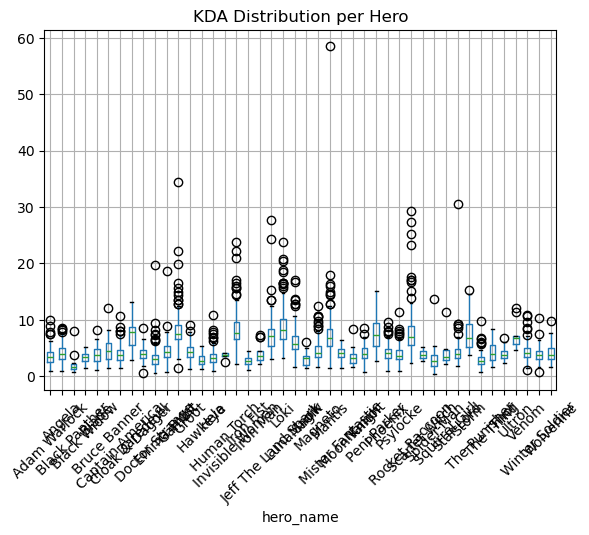

In [28]:
plt.figure(figsize=(35,8))
trimmed_hero_df.boxplot(column="kdaRatio_value", by="hero_name", rot=45)
plt.title("KDA Distribution per Hero")
plt.suptitle("")
plt.show()


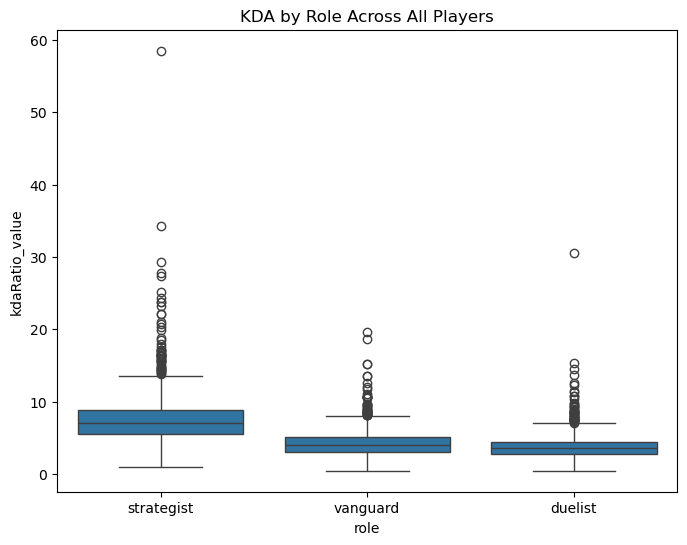

In [29]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(data=trimmed_hero_df, x="role", y="kdaRatio_value")
plt.title("KDA by Role Across All Players")
plt.show()


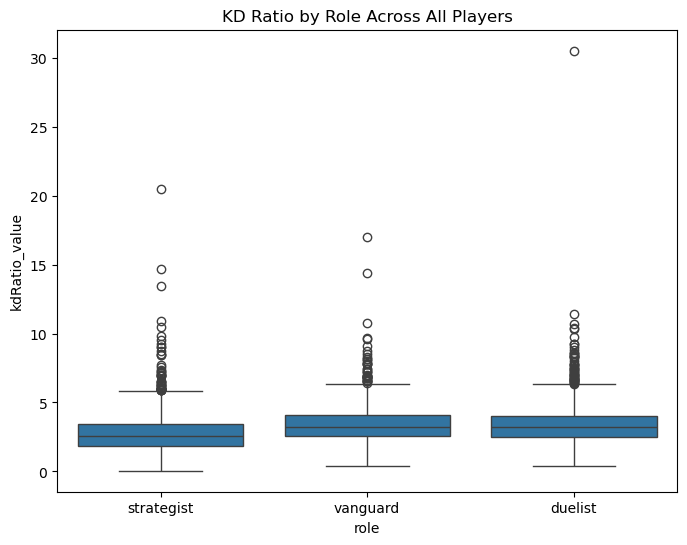

In [30]:
#doing the same but now for KD RATIO since strategists stats are inflated by assists, which the other 2 roles barely get
plt.figure(figsize=(8,6))
sns.boxplot(data=trimmed_hero_df, x="role", y="kdRatio_value")
plt.title("KD Ratio by Role Across All Players")
plt.show()


As expected KD ratio lowers strategists expected results but are higher in vanguard and duelist. 

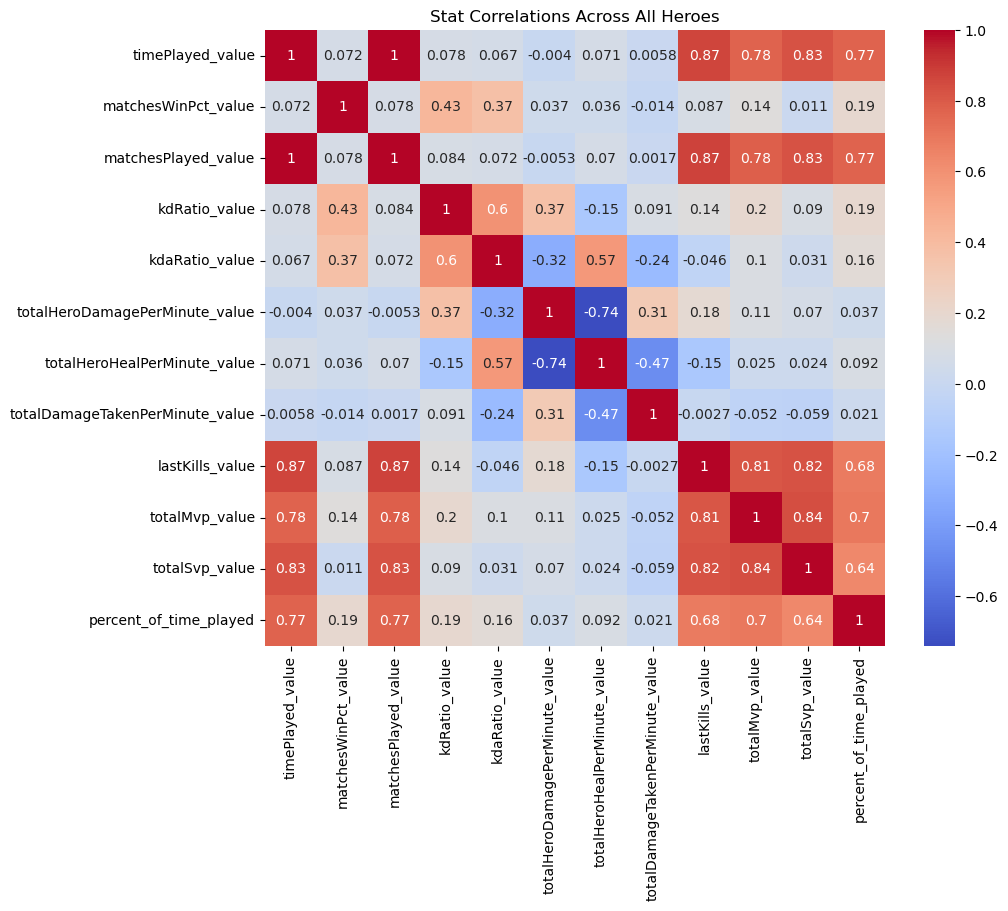

In [31]:
import numpy as np
#trimming data to only have numeric values otherwise cannot make heatmap w/ strings
numbers_only = trimmed_hero_df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numbers_only.corr(), annot=True, cmap="coolwarm")
plt.title("Stat Correlations Across All Heroes")
plt.show()


This is very insightful. I want to do it per role now though, as different stats have different emphasis per role

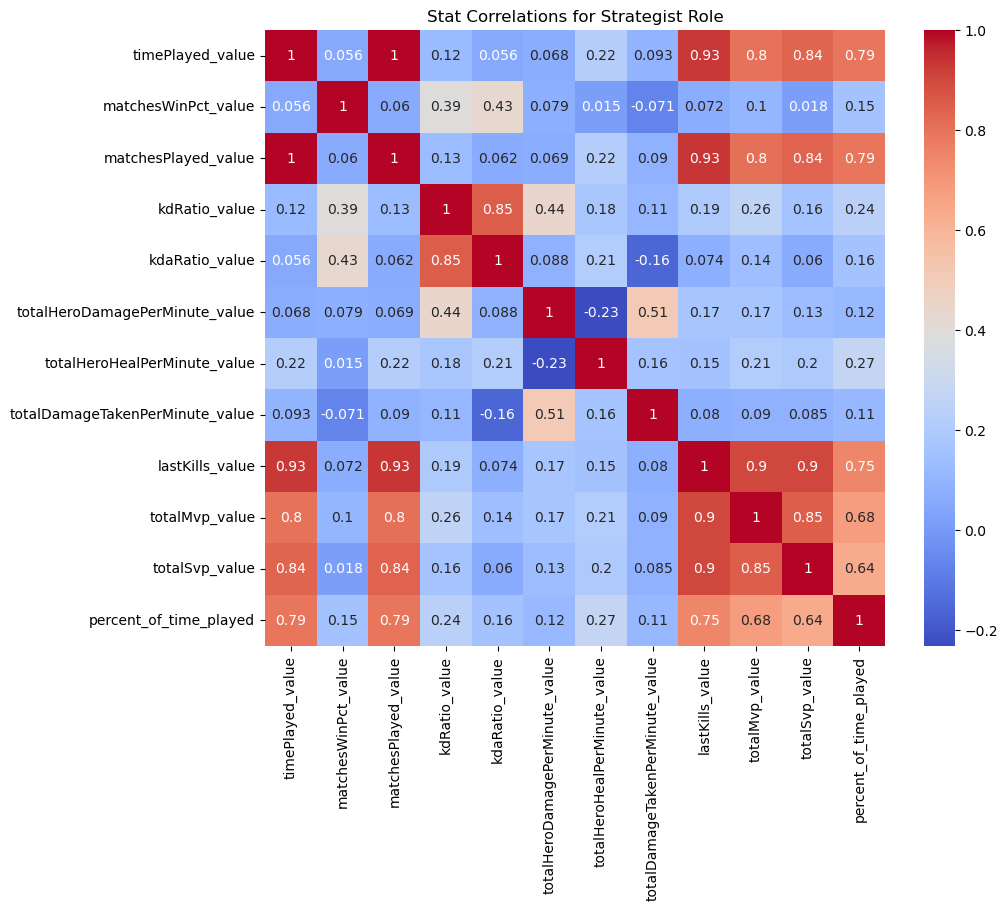

In [32]:
strategist_df = trimmed_hero_df[trimmed_hero_df['role'] == 'strategist']

#trimming data to only have numeric values otherwise cannot make heatmap w/ strings
numbers_only_STRATEGIST = strategist_df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numbers_only_STRATEGIST.corr(), annot=True, cmap="coolwarm")
plt.title("Stat Correlations for Strategist Role")
plt.show()


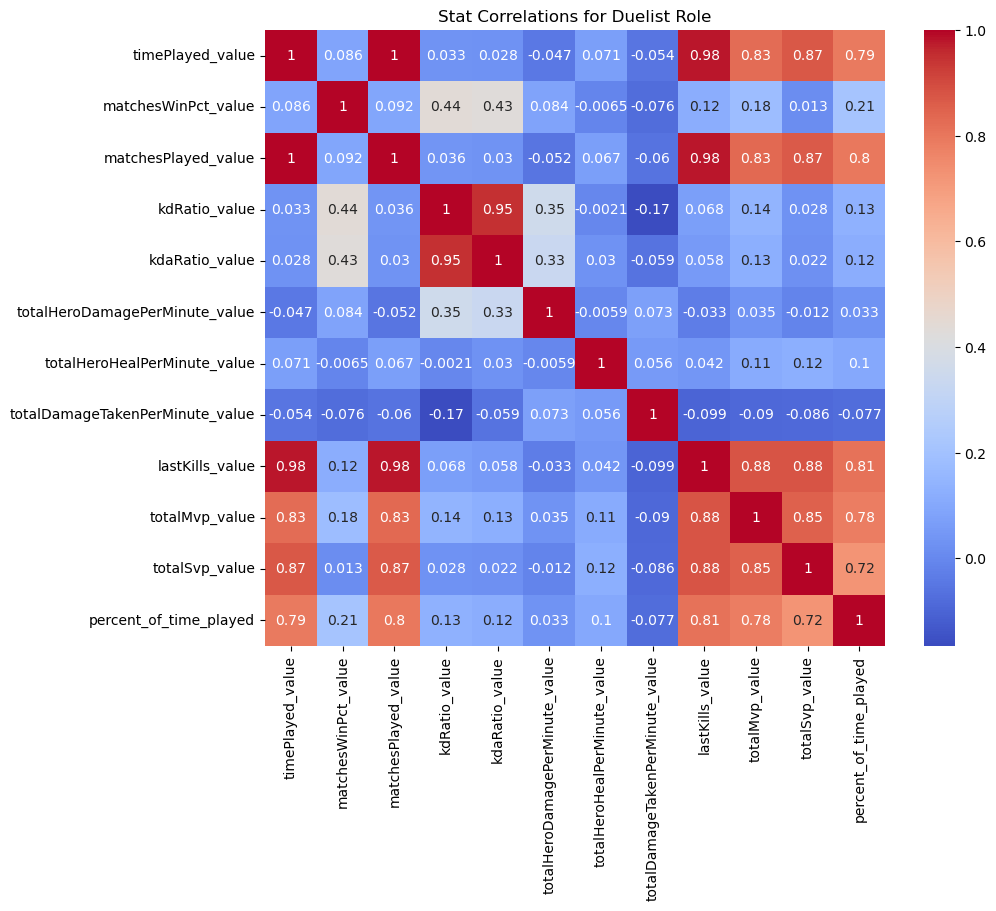

In [33]:
duelist_df = trimmed_hero_df[trimmed_hero_df['role'] == 'duelist']

#trimming data to only have numeric values otherwise cannot make heatmap w/ strings
numbers_only_DUELIST = duelist_df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numbers_only_DUELIST.corr(), annot=True, cmap="coolwarm")
plt.title("Stat Correlations for Duelist Role")
plt.show()


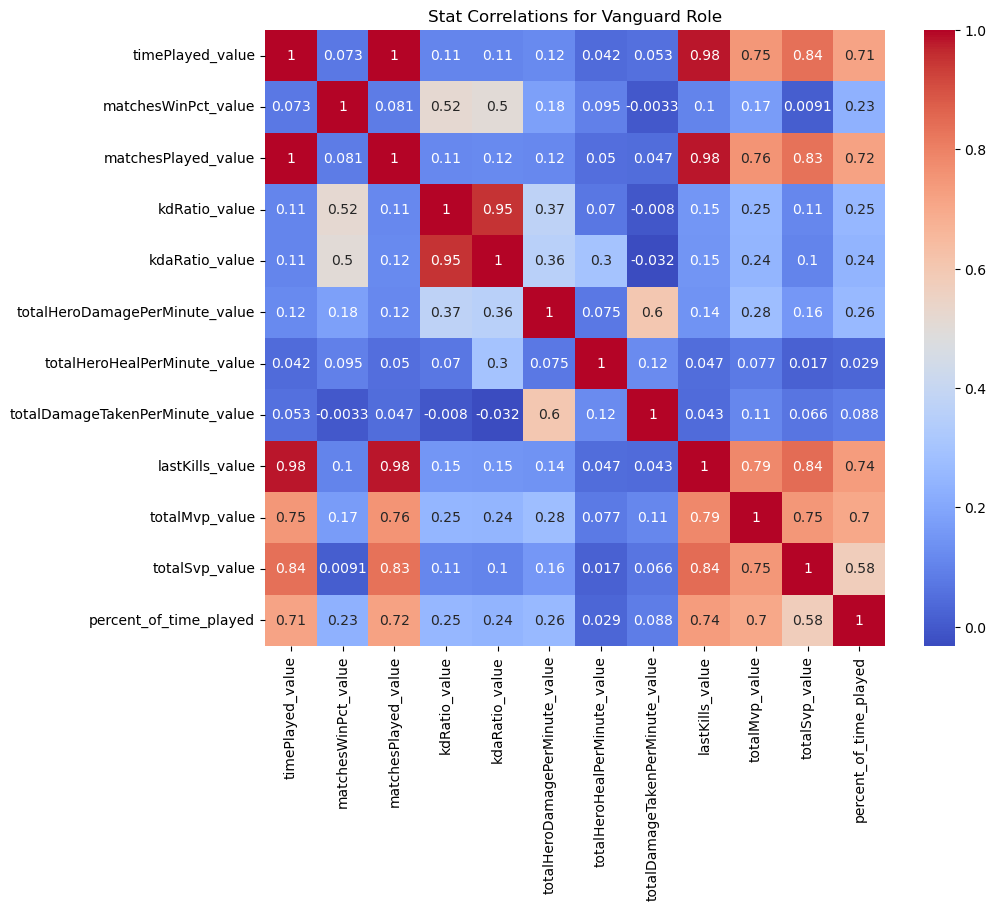

In [34]:
vanguard_df = trimmed_hero_df[trimmed_hero_df['role'] == 'vanguard']

#trimming data to only have numeric values otherwise cannot make heatmap w/ strings
numbers_only_VANGUARD = vanguard_df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numbers_only_VANGUARD.corr(), annot=True, cmap="coolwarm")
plt.title("Stat Correlations for Vanguard Role")
plt.show()


*****
I will create a 2nd notebook to do that. In the meantime, I will make sure to get those values that I mentioned, the win rates per map and per game mode per character that each player played

*****

In [35]:
matches.head()

,id,match_id,replay_id,player_id,player_name,map_name,map_mode,mode_name,timestamp,duration_sec,...,healing_per_min,rank_score,rank_tier,rank_tier_short,rank_delta,last_kills,head_kills,solo_kills,damage_blocked,damage_blocked_per_min
0,1,5513730_1765074019_1318548_11001_12,10858083708,VP Sypeh,VP Sypeh,Celestial Husk,Domination,Competitive,2025-12-07T02:30:35+00:00,381,...,2474.60,5308.0,One Above All,OAA,13.0,1.0,0.0,0.0,6147.800565,1024.63
1,2,6711722_1764888815_1272257_11001_22,50681325737,VP Sypeh,VP Sypeh,Birnin T'Challa,Domination,Competitive,2025-12-04T23:06:27+00:00,537,...,3281.41,5295.0,One Above All,OAA,13.0,3.0,0.0,2.0,11893.105869,1486.64
2,3,6711647_1764886525_1245250_11001_22,50241126491,VP Sypeh,VP Sypeh,Spider-Islands,Convoy,Competitive,2025-12-04T22:36:46+00:00,1015,...,4511.28,5281.0,One Above All,OAA,16.0,6.0,0.0,0.0,25389.681012,1586.86
3,4,506241_1764884213_1311009_11001_21,50560718078,VP Sypeh,VP Sypeh,Arakko,Convoy,Competitive,2025-12-04T22:04:02+00:00,1187,...,4248.56,5264.0,One Above All,OAA,15.0,9.0,0.0,0.0,13422.148777,706.43
4,5,506105_1764882596_1310017_11001_21,50322526242,VP Sypeh,VP Sypeh,Krakoa,Domination,Competitive,2025-12-04T21:29:38+00:00,883,...,3533.89,5248.0,One Above All,OAA,-23.0,5.0,0.0,2.0,22387.621352,1599.12


In [36]:
match_cols = matches.columns.tolist()
pd.Series(match_cols).to_csv("match_columns_list.txt", header=False, index=False)
matches.to_csv("matches_full.csv", sep=",", index=False)

Im gonna make the dataframe with specific columns that I want, and basically drop the other ones, using the similar criteria/logic i defined in the above markdown cell:

In [37]:
matches_filtered = matches[[ 
    "match_id",
    "player_id",
    "player_name",
    "map_name",
    "map_mode",
    "mode_name",
    "timestamp",
    "duration_sec",
    "won",
    "primary_hero",
    "secondary_hero",
    "kills",
    "deaths",
    "assists",
    "damage",
    "healing",
    "kd_ratio",
    "kda_ratio",
    "damage_per_min",
    "healing_per_min",
    "rank_score",
    "rank_tier",
    "rank_tier_short",
    "rank_delta",
    "last_kills",
    "head_kills",
    "solo_kills",
    "damage_blocked",
    "damage_blocked_per_min"
]].copy()


In [38]:
matches_filtered

,match_id,player_id,player_name,map_name,map_mode,mode_name,timestamp,duration_sec,won,primary_hero,...,healing_per_min,rank_score,rank_tier,rank_tier_short,rank_delta,last_kills,head_kills,solo_kills,damage_blocked,damage_blocked_per_min
0,5513730_1765074019_1318548_11001_12,VP Sypeh,VP Sypeh,Celestial Husk,Domination,Competitive,2025-12-07T02:30:35+00:00,381,1,Invisible Woman,...,2474.60,5308.0,One Above All,OAA,13.0,1.0,0.0,0.0,6147.800565,1024.63
1,6711722_1764888815_1272257_11001_22,VP Sypeh,VP Sypeh,Birnin T'Challa,Domination,Competitive,2025-12-04T23:06:27+00:00,537,1,Invisible Woman,...,3281.41,5295.0,One Above All,OAA,13.0,3.0,0.0,2.0,11893.105869,1486.64
2,6711647_1764886525_1245250_11001_22,VP Sypeh,VP Sypeh,Spider-Islands,Convoy,Competitive,2025-12-04T22:36:46+00:00,1015,1,Invisible Woman,...,4511.28,5281.0,One Above All,OAA,16.0,6.0,0.0,0.0,25389.681012,1586.86
3,506241_1764884213_1311009_11001_21,VP Sypeh,VP Sypeh,Arakko,Convoy,Competitive,2025-12-04T22:04:02+00:00,1187,1,Gambit,...,4248.56,5264.0,One Above All,OAA,15.0,9.0,0.0,0.0,13422.148777,706.43
4,506105_1764882596_1310017_11001_21,VP Sypeh,VP Sypeh,Krakoa,Domination,Competitive,2025-12-04T21:29:38+00:00,883,0,Invisible Woman,...,3533.89,5248.0,One Above All,OAA,-23.0,5.0,0.0,2.0,22387.621352,1599.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,5513299_1765089441_1310388_11001_12,Obv,Obv,Krakoa,Domination,Competitive,2025-12-07T06:53:47+00:00,688,1,Rocket Raccoon,...,1491.12,5035.0,Celestial I,C1,17.0,2.0,1.0,0.0,4762.256493,432.93
7125,5514081_1765086328_1272162_11001_12,Obv,Obv,Birnin T'Challa,Domination,Competitive,2025-12-07T05:59:15+00:00,592,1,Namor,...,0.00,5018.0,Celestial I,C1,22.0,18.0,0.0,2.0,4324.097429,480.46
7126,5513907_1765085116_1311435_11001_12,Obv,Obv,Arakko,Convoy,Competitive,2025-12-07T05:40:10+00:00,630,1,Namor,...,0.00,4995.0,Celestial I,C1,22.0,9.0,2.0,1.0,7566.281584,756.63
7127,5518103_1765083979_1291154_11001_11,Obv,Obv,Midtown,Convoy,Competitive,2025-12-07T05:20:55+00:00,605,0,Doctor Strange,...,0.00,4973.0,Celestial I,C1,-20.0,3.0,0.0,0.0,32204.276918,3220.43


In [39]:
#renaming for later convenience in comparing dataframes/merging 
matches_filtered.rename(columns={"primary_hero": "hero_name"}, inplace=True)
matches_filtered.rename(columns={"secondary_hero": "swap_hero"}, inplace=True)

Getting hero win rates per mode: 

In [40]:
hero_mode_wr = (matches_filtered.groupby(["player_id", "hero_name", "map_mode"])["won"].mean().reset_index())
hero_mode_wr.rename(columns={"won": "mode_winrate"}, inplace=True)
hero_mode_wr


,player_id,hero_name,map_mode,mode_winrate
0,-oo- <---MyPig,Angela,Convergence,1.000000
1,-oo- <---MyPig,Angela,Convoy,0.666667
2,-oo- <---MyPig,Angela,Domination,1.000000
3,-oo- <---MyPig,Emma Frost,Convergence,0.666667
4,-oo- <---MyPig,Emma Frost,Convoy,0.333333
...,...,...,...,...
3327,이페,Invisible Woman,Convergence,0.500000
3328,이페,Invisible Woman,Convoy,1.000000
3329,이페,Invisible Woman,Domination,0.833333
3330,이페,Loki,Convoy,0.666667


In [41]:
print(hero_mode_wr[hero_mode_wr['player_id'] == 'VP Sypeh'])

     player_id        hero_name     map_mode  mode_winrate
1900  VP Sypeh     Adam Warlock   Domination      1.000000
1901  VP Sypeh           Gambit  Convergence      1.000000
1902  VP Sypeh           Gambit       Convoy      1.000000
1903  VP Sypeh           Gambit   Domination      0.000000
1904  VP Sypeh  Invisible Woman  Convergence      0.666667
1905  VP Sypeh  Invisible Woman       Convoy      1.000000
1906  VP Sypeh  Invisible Woman   Domination      0.714286
1907  VP Sypeh             Loki  Convergence      1.000000
1908  VP Sypeh             Loki       Convoy      1.000000
1909  VP Sypeh             Loki   Domination      1.000000
1910  VP Sypeh           Mantis       Convoy      0.000000
1911  VP Sypeh   Rocket Raccoon       Convoy      1.000000


getting winrate averages per player per hero and on each map

In [42]:
hero_map_wr = (matches_filtered.groupby(["player_id", "hero_name", "map_name"])["won"].mean().reset_index())
hero_map_wr.rename(columns={"won": "map_winrate"}, inplace=True)
hero_map_wr


,player_id,hero_name,map_name,map_winrate
0,-oo- <---MyPig,Angela,Arakko,1.0
1,-oo- <---MyPig,Angela,Central Park,1.0
2,-oo- <---MyPig,Angela,Heart Of Heaven,1.0
3,-oo- <---MyPig,Angela,Hell's Heaven,1.0
4,-oo- <---MyPig,Angela,Spider-Islands,0.5
...,...,...,...,...
5518,이페,Invisible Woman,Krakoa,1.0
5519,이페,Invisible Woman,Midtown,1.0
5520,이페,Loki,Arakko,1.0
5521,이페,Loki,Celestial Husk,1.0


In [43]:
print(hero_map_wr['map_name'].unique())

['Arakko' 'Central Park' 'Heart Of Heaven' "Hell's Heaven"
 'Spider-Islands' "Birnin T'Challa" 'Symbiotic Surface' 'Yggdrasill Path'
 'Hall Of Djalia' 'Midtown' 'Celestial Husk' 'Krakoa' 'Royal Palace']


matches 

In [44]:
match_id_master_list2 = matches['replay_id'].unique()
pd.Series(match_id_master_list2).to_csv("replay_id_master_list.txt", header=False, index=False)
print(len(match_id_master_list2))
match_id_master_list2

5418


array(['10858083708', '50681325737', '50241126491', ..., '10763867560',
       '10526273578', '10227671935'], shape=(5418,), dtype=object)

want to merge the trimmed hero df data and the average win rates for maps and modes so i can use it in the models

In [45]:
trimmed_hero_df.head()

,player_id,hero_name,role,timePlayed_value,matchesWinPct_value,matchesPlayed_value,kdRatio_value,kdaRatio_value,totalHeroDamagePerMinute_value,totalHeroHealPerMinute_value,totalDamageTakenPerMinute_value,lastKills_value,totalMvp_value,totalSvp_value,percent_of_time_played
0,VP Sypeh,Gambit,strategist,37388.742,69.135802,48.6,4.075556,9.626667,881.0,2983.0,682.0,280,18,7,55.159494
1,VP Sypeh,Invisible Woman,strategist,14769.481,63.934426,18.3,4.962500,11.475000,1294.0,3169.0,1516.0,79,7,5,21.789369
2,VP Sypeh,Emma Frost,vanguard,1275.047,71.428571,1.4,3.363636,4.545455,2404.0,0.0,3061.0,13,0,0,1.881073
3,VP Sypeh,Loki,strategist,7069.450,93.220339,11.8,5.400000,13.400000,957.0,2267.0,511.0,31,4,0,10.429537
4,VP Sypeh,Adam Warlock,strategist,2216.817,53.333333,3.0,2.750000,4.850000,1272.0,1596.0,727.0,28,0,0,3.270463


In [46]:
hero_map_wr.head()

,player_id,hero_name,map_name,map_winrate
0,-oo- <---MyPig,Angela,Arakko,1.0
1,-oo- <---MyPig,Angela,Central Park,1.0
2,-oo- <---MyPig,Angela,Heart Of Heaven,1.0
3,-oo- <---MyPig,Angela,Hell's Heaven,1.0
4,-oo- <---MyPig,Angela,Spider-Islands,0.5


In [47]:
hero_mode_wr.head()

,player_id,hero_name,map_mode,mode_winrate
0,-oo- <---MyPig,Angela,Convergence,1.000000
1,-oo- <---MyPig,Angela,Convoy,0.666667
2,-oo- <---MyPig,Angela,Domination,1.000000
3,-oo- <---MyPig,Emma Frost,Convergence,0.666667
4,-oo- <---MyPig,Emma Frost,Convoy,0.333333


*****
I dont know how to best merge these datasets together, so first I'm going to use the trimmed hero dataframe to try and use that in a model, see the effects, and then try to merge them and try to model there. I expect trial and error but hopefully i can build a decent model this way
*****

In [48]:
#saving all of the dataframes to csv so i can load in separate notebook for modeling 
trimmed_hero_df.to_csv("trimmed_hero_data.csv", sep=",", index=False)
hero_map_wr.to_csv("hero_map_winrate.csv", sep=",", index=False)
hero_mode_wr.to_csv("hero_mode_winrate.csv", sep=",", index=False)